In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electricity-load-forecasting/train_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/continuous dataset.csv
/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx
/kaggle/input/electricity-load-forecasting/weekly pre-dispatch forecast.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import zipfile
from statsmodels.tsa.seasonal import seasonal_decompose

2025-05-04 13:57:26.764266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746367047.040226      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746367047.124376      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import pandas as pd

# Load the data from the given paths
train_df = pd.read_excel('/kaggle/input/electricity-load-forecasting/train_dataframes.xlsx')
test_df = pd.read_excel('/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx')
continuous_df = pd.read_csv('/kaggle/input/electricity-load-forecasting/continuous dataset.csv')
forecast_df = pd.read_csv('/kaggle/input/electricity-load-forecasting/weekly pre-dispatch forecast.csv')

# Show a few rows of each dataset to understand their structure
print("Train Data:")
print(train_df.head())

print("\nTest Data:")
print(test_df.head())

print("\nContinuous Data:")
print(continuous_df.head())

print("\nForecast Data:")
print(forecast_df.head())


Train Data:
             datetime  week_X-2  week_X-3  week_X-4      MA_X-4  dayOfWeek  \
0 2015-01-31 01:00:00  962.2865  906.9580  970.3450  938.004850          1   
1 2015-01-31 02:00:00  933.3221  863.5135  912.1755  900.284075          1   
2 2015-01-31 03:00:00  903.9817  848.4447  900.2688  881.704325          1   
3 2015-01-31 04:00:00  900.9995  839.8821  889.9538  876.458825          1   
4 2015-01-31 05:00:00  904.3481  847.1073  893.6865  879.190775          1   

   weekend  holiday  Holiday_ID  hourOfDay    T2M_toc    DEMAND  
0        1        0           0          1  25.308496  954.2018  
1        1        0           0          2  25.141443  913.8660  
2        1        0           0          3  25.006738  903.3637  
3        1        0           0          4  24.899713  889.0806  
4        1        0           0          5  24.821558  910.1472  

Test Data:
             datetime   week_X-2   week_X-3   week_X-4       MA_X-4  \
0 2019-04-13 01:00:00  1064.7486  1204.5

In [4]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())
print(continuous_df.isnull().sum())
print(forecast_df.isnull().sum())


datetime      0
week_X-2      0
week_X-3      0
week_X-4      0
MA_X-4        0
dayOfWeek     0
weekend       0
holiday       0
Holiday_ID    0
hourOfDay     0
T2M_toc       0
DEMAND        0
dtype: int64
datetime      0
week_X-2      0
week_X-3      0
week_X-4      0
MA_X-4        0
dayOfWeek     0
weekend       0
holiday       0
Holiday_ID    0
hourOfDay     0
T2M_toc       0
DEMAND        0
dtype: int64
datetime      0
nat_demand    0
T2M_toc       0
QV2M_toc      0
TQL_toc       0
W2M_toc       0
T2M_san       0
QV2M_san      0
TQL_san       0
W2M_san       0
T2M_dav       0
QV2M_dav      0
TQL_dav       0
W2M_dav       0
Holiday_ID    0
holiday       0
school        0
dtype: int64
datetime         0
load_forecast    0
dtype: int64


In [5]:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
continuous_df['datetime'] = pd.to_datetime(continuous_df['datetime'])
forecast_df['datetime'] = pd.to_datetime(forecast_df['datetime'])


In [6]:
# Extract more time-based features
train_df['day'] = train_df['datetime'].dt.day
train_df['month'] = train_df['datetime'].dt.month
train_df['year'] = train_df['datetime'].dt.year
train_df['hour'] = train_df['datetime'].dt.hour
train_df['day_of_week'] = train_df['datetime'].dt.dayofweek
train_df['is_weekend'] = (train_df['day_of_week'] >= 5).astype(int)  # Weekend feature (1 for weekend, 0 for weekday)

# Create rolling averages for previous weeks (lagging features)
train_df['week_X-2'] = train_df['DEMAND'].shift(2)
train_df['week_X-3'] = train_df['DEMAND'].shift(3)
train_df['week_X-4'] = train_df['DEMAND'].shift(4)
train_df['MA_X-4'] = train_df['DEMAND'].rolling(window=4).mean()  # Moving average for 4 hours


In [8]:
# Check the column names in the dataset
print(train_df.columns)


Index(['datetime', 'week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek',
       'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc', 'DEMAND',
       'day', 'month', 'year', 'hour', 'day_of_week', 'is_weekend'],
      dtype='object')


In [10]:
# List of available weather columns in your dataset
weather_columns = ['T2M_toc']

# Initialize the scaler
scaler = MinMaxScaler()

# Apply MinMaxScaler to the available weather columns
train_df[weather_columns] = scaler.fit_transform(train_df[weather_columns])

# Check if the normalization was applied
print(train_df[weather_columns].head())


    T2M_toc
0  0.194855
1  0.181033
2  0.169888
3  0.161033
4  0.154566


In [12]:
# Create additional time-related features
train_df['day'] = train_df['datetime'].dt.day
train_df['month'] = train_df['datetime'].dt.month
train_df['year'] = train_df['datetime'].dt.year
train_df['hour'] = train_df['datetime'].dt.hour
train_df['day_of_week'] = train_df['datetime'].dt.dayofweek
train_df['is_weekend'] = train_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Optionally, add rolling averages for previous weeks (e.g., week_X-2, week_X-3, etc.)
train_df['week_X-2'] = train_df['DEMAND'].shift(2)
train_df['week_X-3'] = train_df['DEMAND'].shift(3)
train_df['week_X-4'] = train_df['DEMAND'].shift(4)
train_df['MA_X-4'] = train_df['DEMAND'].rolling(window=4).mean()


In [13]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = train_df[['week_X-2', 'week_X-3', 'week_X-4', 'MA_X-4', 'dayOfWeek', 'weekend', 'holiday', 'Holiday_ID', 'hourOfDay', 'T2M_toc']]
y = train_df['DEMAND']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the split data
print(X_train.head(), y_train.head())


        week_X-2   week_X-3   week_X-4       MA_X-4  dayOfWeek  weekend  \
20853  1257.0826  1269.8889  1203.1209  1233.796400          1        1   
14284   972.7560   996.8049  1027.6724   968.514950          1        1   
1512    973.6255  1003.0428  1019.6752   954.786050          1        1   
9733   1465.8428  1468.8683  1446.2956  1488.466225          7        0   
20859  1010.1294  1044.2038  1087.7944  1004.390550          2        1   

       holiday  Holiday_ID  hourOfDay   T2M_toc  
20853        0           0         22  0.263639  
14284        0           0          5  0.286164  
1512         1          10          1  0.246080  
9733         0           0         14  0.782571  
20859        0           0          4  0.232965   20853    1183.6297
14284     943.3391
1512      903.9480
9733     1513.3888
20859     971.2921
Name: DEMAND, dtype: float64


In [15]:
# Remove rows with NaN values
X_train = X_train.dropna()
y_train = y_train[X_train.index]


In [16]:
from sklearn.impute import SimpleImputer

# Initialize the imputer (using mean strategy)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the train features
X_train_imputed = imputer.fit_transform(X_train)

# Transform the test features as well
X_test_imputed = imputer.transform(X_test)


In [17]:
# Remove rows with NaN values
X_train = X_train.dropna()
y_train = y_train[X_train.index]

# Now you can train the model
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [18]:
from sklearn.impute import SimpleImputer

# Initialize the imputer (using mean strategy)
imputer = SimpleImputer(strategy='mean')

# Apply the imputer on the features
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Now train the model on the imputed data
rf_model.fit(X_train_imputed, y_train)


RandomForestRegressor(random_state=42)

In [19]:
# Make predictions
y_pred = rf_model.predict(X_test_imputed)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')


Mean Squared Error: 225.29055750708451
R-squared: 0.9939022842423368


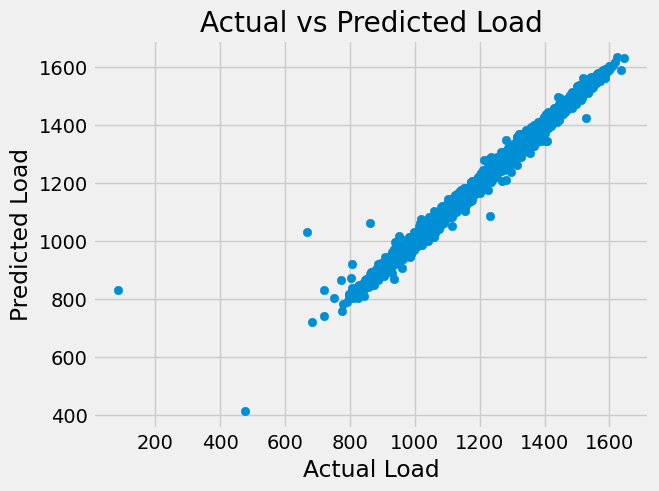

In [20]:
# Visualizing the actual vs predicted values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Load")
plt.ylabel("Predicted Load")
plt.title("Actual vs Predicted Load")
plt.show()


In [21]:
df1=pd.read_csv('/kaggle/input/electricity-load-forecasting/continuous dataset.csv',index_col=[0],parse_dates=[0])
df2=pd.read_excel('/kaggle/input/electricity-load-forecasting/test_dataframes.xlsx',index_col=[0],parse_dates=[0])
df3=pd.read_excel('/kaggle/input/electricity-load-forecasting/train_dataframes.xlsx',index_col=[0],parse_dates=[0])
df4=pd.read_csv('/kaggle/input/electricity-load-forecasting/weekly pre-dispatch forecast.csv',index_col=[0],parse_dates=[0]);
df1


,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
datetime,,,,,,,,,,,,,,,,
2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26 20:00:00,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1
2020-06-26 21:00:00,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1
2020-06-26 22:00:00,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1


In [22]:
df1_refined=df1['nat_demand'].resample('D').mean()
df1_refined

datetime
2015-01-03    1069.266587
2015-01-04    1008.123596
2015-01-05    1146.682925
2015-01-06    1143.394429
2015-01-07    1144.098817
                 ...     
2020-06-23    1137.366342
2020-06-24    1131.196625
2020-06-25    1184.028708
2020-06-26    1106.277696
2020-06-27    1013.568300
Freq: D, Name: nat_demand, Length: 2003, dtype: float64

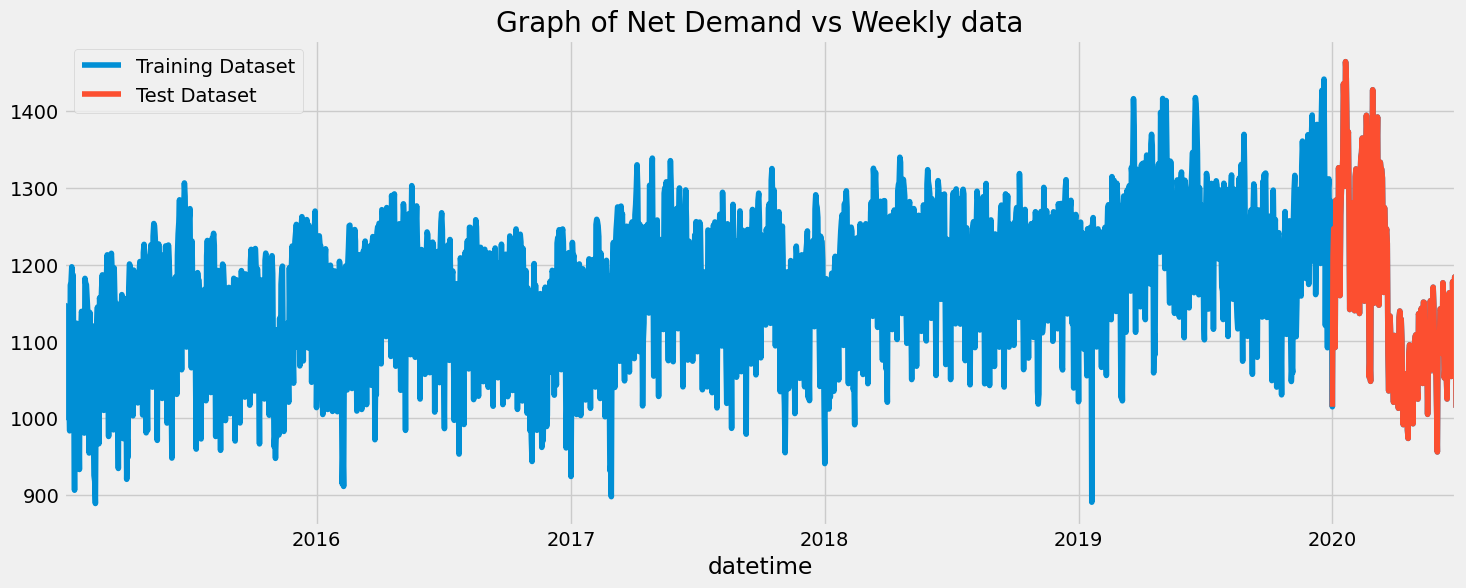

In [23]:
df1_refined[:'2020'].plot(figsize=(16,6),legend=True)
df1_refined['2020':].plot(figsize=(16,6),legend=True)
plt.legend(['Training Dataset','Test Dataset'])
plt.title('Graph of Net Demand vs Weekly data')
plt.show()

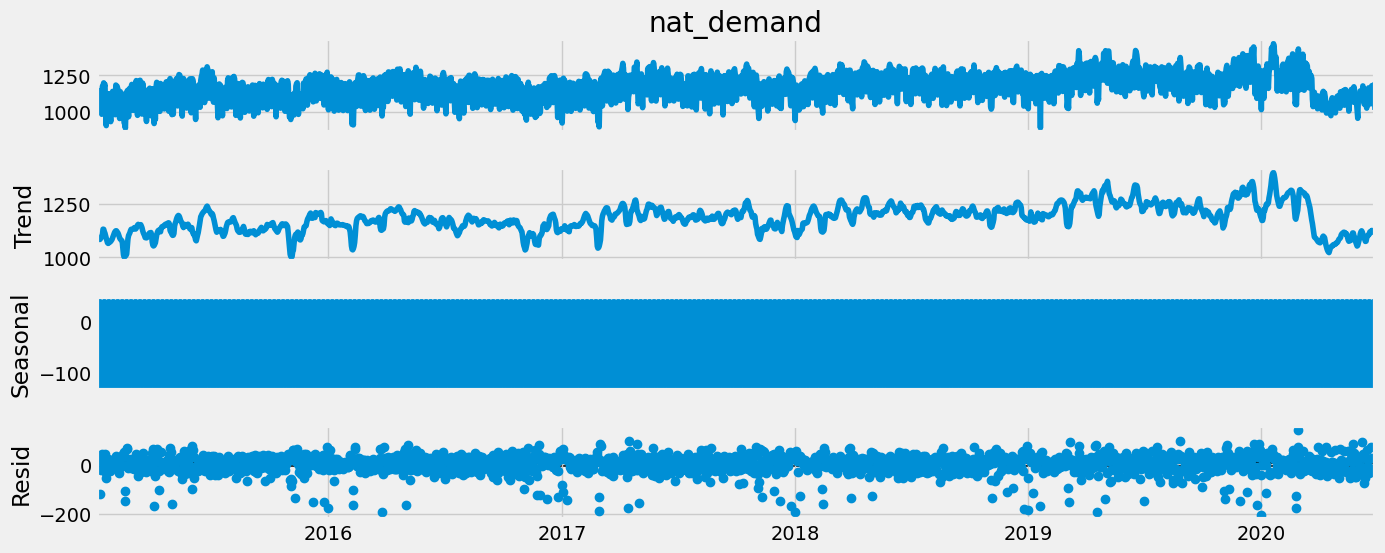

In [24]:
decomp = seasonal_decompose(df1_refined[:])
fig = decomp.plot()
fig.set_figheight(6)
fig.set_figwidth(16)

In [27]:
training_set = df1_refined[:'2020'].values
test_set = df1_refined['2020'].values
training_set=training_set.reshape((training_set.shape[0],1))
test_set=test_set.reshape((test_set.shape[0],1))
print("Training Set Shape : ",training_set.shape)
print("Test Set Shape : ",test_set.shape)

Training Set Shape :  (2003, 1)
Test Set Shape :  (179, 1)


In [28]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(2003, 1)

In [29]:
X_train = []
Y_train = []
for i in range(100,2003):
    X_train.append(training_set_scaled[i-100:i,0])
    Y_train.append(training_set_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [30]:
EPOCHS=50

model = Sequential()
model.add(GRU(64, activation='tanh',return_sequences=True, input_shape=(100, 1)))
model.add(LSTM(64, activation='tanh',return_sequences=True))
model.add(GRU(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
#opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

2025-05-04 14:09:54.310104: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 100, 64)             │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          17,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,339 (247.42 KB)

 Trainable params: 63,339 (247.42 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.fit(X_train,Y_train, epochs=EPOCHS, batch_size=72, shuffle=False)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 325ms/step - accuracy: 7.6454e-05 - loss: 0.0877
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - accuracy: 7.6454e-05 - loss: 0.0247
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 7.6454e-05 - loss: 0.0226
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - accuracy: 7.6454e-05 - loss: 0.0228
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 7.6454e-05 - loss: 0.0221
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 242ms/step - accuracy: 7.6454e-05 - loss: 0.0224
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - accuracy: 7.6454e-05 - loss: 0.0225
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 7.6454e-05 - loss: 0.0222
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - accuracy: 7.6454e-05 - loss: 0.0223
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 7.6454e-05 - loss: 0.0225
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 7.6454e-05 - loss: 0.0227
Epoch 1

In [32]:
dataset_total = pd.concat((df1_refined[:'2020'],df1_refined['2020':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 100:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [33]:
X_test = []
for i in range(100,279):
    X_test.append(inputs[i-100:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_data = model.predict(X_test)
predicted_data = sc.inverse_transform(predicted_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step


In [36]:
import matplotlib.pyplot as plt

def plot_predictions(actual_data, predicted_data, title="Actual vs Predicted"):
    # Make sure both the actual and predicted data are of the same length
    plt.figure(figsize=(10,6))
    
    # Plot actual values
    plt.plot(actual_data, color='blue', label='Actual')
    
    # Plot predicted values
    plt.plot(predicted_data, color='red', label='Predicted')
    
    # Adding labels and title
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Load')
    plt.legend(loc='upper left')
    
    # Show the plot
    plt.show()
